In [27]:
from IPython.display import display, Image, HTML
from ipywidgets import Button, Output
import os

path = "Si_nano_muestra_3/"
extetion = ".png"
files = []

for r, d, f in os.walk(path):
    for file in f:
        if extetion in file:
            files.append(r+'/'+file)

# List of image file names
image_files = files

# Current image index
current_image_index = 0

# Output widget to display the image
out = Output()

# Function to update and display the current image
def display_image():
    with out:
        # Clear the output area
        out.clear_output()
        # Get the current image file name
        image_file = image_files[current_image_index]
        # Display the image
        display(Image(retina=False,filename=image_file, metadata={'Title': 'Hello'}))
        # Add the file name to the image
        file_name = os.path.basename(image_file)
        # Display the text next to the image
        text = "<b>" + file_name + "</b>"
        #display(HTML("<div style='float: center; font-size: 50px;'><center><br>" + text + "<br>" + text + "<br>" + text + "</center></div>"))

# Button click event handlers
def previous_image(btn):
    global current_image_index
    current_image_index = (current_image_index - 1) % len(image_files)
    display_image()

def next_image(btn):
    global current_image_index
    current_image_index = (current_image_index + 1) % len(image_files)
    display_image()

# Create buttons
previous_button = Button(description='Previous')
previous_button.on_click(previous_image)

next_button = Button(description='Next')
next_button.on_click(next_image)

# Display buttons and output widget
display(previous_button, next_button)
display(out)

# Display initial image
display_image()

Button(description='Previous', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

Output()

In [2]:
import os

path = "../raman_2"
extetion = ".txt"
files = []

for r, d, f in os.walk(path):
    for file in f:
        if extetion in file:
            files.append(r+'/'+file)

files

['../raman_2/Si_nano_muestra 3_01.txt',
 '../raman_2/Si_nano_muestra 3_16.txt',
 '../raman_2/Si_nano_muestra 3_17.txt',
 '../raman_2/Si_nano_muestra 3_25.txt',
 '../raman_2/Si_nano_muestra 3_31.txt',
 '../raman_2/Si_nano_muestra 3_32.txt',
 '../raman_2/Si_nano_muestra 3_33.txt',
 '../raman_2/Si_nano_muestra 3_34.txt',
 '../raman_2/Si_nano_muestra 3_37.txt',
 '../raman_2/Si_nano_muestra 3_38.txt',
 '../raman_2/Si_nano_muestra 3_46.txt',
 '../raman_2/Si_nano_muestra 3_48.txt',
 '../raman_2/Si_nano_muestra 3_52.txt',
 '../raman_2/Si_nano_muestra 3_57.txt',
 '../raman_2/Si_nano_muestra 3_59.txt',
 '../raman_2/Si_nano_muestra 3_60.txt',
 '../raman_2/Si_nano_muestra 3_62.txt',
 '../raman_2/Si_nano_muestra 3_63.txt',
 '../raman_2/Si_nano_muestra 3_64.txt',
 '../raman_2/Si_nano_muestra 3_65.txt']

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt



class RamanSpectrum:
    """
    A Class to perform ploting, cutting spectrums in a certain range
    denoise, baseline and multipeak fit. It needs the path of a 
    RamanSpectrum of type txt. It should be noted that the format of this txt 
    may be different for an observation made in another device. But in general the main
    part is inside the x,y pairs so the read of another type of format can be modified to
    provide x, and yas an np array in the initialization method.
    """

    def __init__(self, filepath, x=None,y=None):
        # Read in the data from the file or reading the x, y values

        with open(filepath, 'r', encoding='iso-8859-1') as f:
            lines = f.readlines()
        
        # Extract the metadata from the file
        self.metadata = {}
        # Creating an empty dictionary to store the coordinates
        self.dictcoords = {}

        for line in lines:
            if line.startswith("#"):
                # Storing the metadata
                key, value = line.strip().split("=")
                self.metadata[key[1:]] = value.replace('\t', '')
        
        # Now that we have the metadata stored in a dictionary, we can
        # store the value of the keys in a set of strings

        self.metakeys = self.metadata.keys()
        
        # Extract the x and y data from the file
        
        self.data = np.loadtxt(lines[len(self.metadata):])
        self.x = self.data[:,0]
        self.y = self.data[:,1]

        self.sample = self.metadata['Acquired'].replace(' ', '_')

        # Creating a folder to store the data
        if not os.path.exists(self.sample):
            os.makedirs(self.sample)
        
        # Saving the data as an dictionary
        for e in self.data:
            self.dictcoords[e[0]] = e[1]
    
    def plot(self):
        """Plotting the data"""
        plt.plot(self.x, self.y)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.show()

    def acces_value(self, pattern):
        matched_keys = set()
        regex = re.compile(pattern, re.IGNORECASE)
        for key in self.metakeys:
            if regex.search(key):
                matched_keys.add(key)
        return (matched_keys, [self.metadata[key] for key in matched_keys])
    
    def crop(self, lower, upper, show = False):
        """
        This method crops the x and y values to only a subset of the 
        original points. It also plots the cropped data if the show
        parameter is set to True. Always saves the cropped data as an
        image.
        """
        self.croppedx = []
        self.croppedy = []
        for e in self.x:
            if e > lower and e < upper:
                self.croppedx.append(e)
                self.croppedy.append(self.dictcoords[e])
        plt.plot(self.croppedx, self.croppedy)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title(self.metadata['Date'])
        # Saving the cropped data as an image

        if not os.path.exists(self.sample+'/cropped'):
            os.makedirs(self.sample+'/cropped')

        name = self.sample+"/cropped/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        if show:
            plt.show()
        plt.clf()
    
    def polifit(self, a,b,ord = 3):
        """
        a is the lowest value of the x pairs and b
        is the highest value. ord is the order of the polynomial
        to be fitted
        """
        
        x = []
        y = []
        for x_i, y_i in zip(self.croppedx,self.croppedy):
            if x_i < a or x_i > b:
                x.append(x_i)
                y.append(y_i)
        # Fitting the data
        fitted = np.polyfit(x, y, ord)

        # Plotting the first part
        plt.subplot(2, 1, 1)  # Create subplot 1
        plt.plot(self.croppedx, self.croppedy)
        plt.plot(self.croppedx, np.polyval(fitted, self.croppedx))
        plt.xlim(min(self.croppedx), max(self.croppedx))
        ef = abs(max(self.croppedy) - min(self.croppedy))/20
        plt.ylim(min(self.croppedy)-ef, max(self.croppedy)+ef)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('With baseline')
        # Plotting the second part
        plt.subplot(2, 1, 2)  # Create subplot 2
        plt.plot(self.croppedx, self.croppedy - np.polyval(fitted, self.croppedx))
        self.polylx = self.croppedx
        self.polyly = self.croppedy - np.polyval(fitted, self.croppedx)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('Without baseline')

        # Saving both plots in the same file
        if not os.path.exists(self.sample+'/polyfit'):
            os.makedirs(self.sample+'/polyfit')
        plt.savefig(self.sample+"/polyfit/{i}.png".format(i=self.metadata['Date']))
        plt.subplots_adjust(hspace=1)
        plt.show()
    
    def sav_gol(self, window, order, x_arr,y_arr, show=False):
        """
        Takes the x and y values and applies a Savitzky-Golay filter
        sets self.denoisedx and self.denoisedy to the denoised values
        """
        self.denoisedx = []
        self.denoisedy = []    
        self.savgol = savgol_filter(y_arr, window, order)
        self.denoisedx = x_arr
        self.denoisedy = self.savgol
        plt.plot(self.denoisedx, self.denoisedy)
        self.basedx = self.denoisedx
        self.basedy = self.denoisedy
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('Denoised')

        if not os.path.exists(self.sample+'/denoised'):
            os.makedirs(self.sample+'/denoised')

        # Saving the cropped data as an image
        name = self.sample + "/denoised/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        if show:
            plt.show()
        plt.clf()

    def baseline(self,degree = 1, show = False, before=False):
        # Fit polynomial baseline

        xfit = self.denoisedx[:5] + self.denoisedx[-5:]
        self.a = list(self.denoisedy[:5])
        self.b = list(self.denoisedy[-5:])
        
        print(self.a)
        print(self.b)

        yfit = self.a + self.b
        print(type(self.denoisedx),type(self.denoisedy))
        print('The lenghts',len(xfit),len(yfit))

        coefficients = np.polyfit(xfit, yfit, degree)
        baseline = np.polyval(coefficients, self.denoisedx)

        # Plot the original signal and the baseline
        # plt.plot(self.denoisedx, self.denoisedy, label='Original Signal')
        new_zero = abs(min(self.denoisedy - baseline))
        if before:
            plt.plot(self.denoisedx, (self.croppedy + new_zero)  , label='baselined')
            plt.plot(self.denoisedx, baseline, label='Baseline')
        else:
            plt.plot(self.denoisedx, (self.denoisedy + new_zero), label='baselined')
            plt.plot(self.denoisedx, baseline, label='Baseline')
        self.basedx = self.denoisedx
        self.basedy = (self.denoisedy + new_zero) - baseline
        # plt.plot(self.denoisedx, baseline, label='Baseline')
        plt.legend()
        plt.xlabel('wavenumber (cm$^{-1}$)')
        plt.ylabel('Intensity (counts)')

        if not os.path.exists(self.sample+'/baseline'):
            os.makedirs(self.sample+'/baseline')

        plt.title(self.metadata['Date'] + ' - Baseline')
        if show:
            plt.show()
        name = self.sample + "/baseline/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        plt.clf()
    

    # Define the function as the sum of three Gaussian curves
    def gaussian(self, x, amplitude, center, sigma):
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

    def multi_peak_fit(self, x, *params):
        num_peaks = len(params) // 3
        y_fit = np.zeros_like(x)

        for i in range(num_peaks):
            amplitude, center, sigma = params[i*3 : (i+1)*3]
            y_fit += self.gaussian(x, amplitude, center, sigma)
        return y_fit
    
    def get_fitting(self, f2 = 0.5, f3 = 0.3 , c1 = 520, c2 = 500, c3 = 480, s1 = 10, s2 = 20, s3 = 40 ,show = False):
        x = np.array(self.basedx)
        y = np.array(self.basedy)

        yspec = max(y)
        yspec2 = yspec*f2
        yspec3 = yspec*f3

        # Perform the multi-peak fitting
        # initial_guess = [yspec3, 450, 100, yspec2, 510, 10, yspec, 520, 10]
        initial_guess = [yspec3, c3, s3, yspec2, c2, s2, yspec, c1, s1]   # Initial guess for parameters: [amplitude1, center1, sigma1, amplitude2, center2, sigma2, amplitude3, center3, sigma3]
        
        if not os.path.exists(self.sample+'/fit'):
                os.makedirs(self.sample+'/fit')

        popt, pcov = curve_fit(self.multi_peak_fit, x, y, p0=initial_guess)

        # Extract the optimized parameters
        amplitudes = popt[0::3]
        centers = popt[1::3]
        sigmas = popt[2::3]

        for i in range(0,3):
            amp,cen,sig = popt[i*3:(i+1)*3]

        self.fit_props = popt

        # Print the results

        print('Amplitudes: {}'.format(amplitudes))
        print('Centers: {}'.format(centers))
        print('Sigmas: {}'.format(sigmas))

        # Generate the fitted curve
        x_fit = np.linspace(x.min(), x.max(), 1000)
        y_fit = self.multi_peak_fit(x_fit, *popt)
        # Plot the original data and the fitted curve
        plt.plot(x, y, 'bo', label='Original Data')
        plt.plot(x_fit, y_fit, 'r-', label='Fitted Curve')
        self.x_fit = x_fit
        self.y_fit = y_fit
        plt.legend()
        plt.xlabel('wavenumber (cm$^{-1}$)')
        plt.ylabel('Counts (a.u.)')
        if show:
            plt.show()
        plt.savefig(self.sample+'/fit/{}.png'.format(self.metadata['Date']))
        self.popt = popt
        plt.clf()

    # def get_fitting(self, x_,y_, f2 = 0.5, f3 = 0.3 , c1 = 520, c2 = 500, c3 = 480, s1 = 10, s2 = 20, s3 = 40 ,show = False):
    #     """
    #     A multi-peak fitting function that takes the x and y values and fits them to a multi-peak function
    #     """
    #     x = np.array(x_)
    #     y = np.array(y_ + abs(min(y_)))

    #     yspec = max(y)
    #     yspec2 = yspec*f2
    #     yspec3 = yspec*f3

    #     # Perform the multi-peak fitting
    #     # initial_guess = [yspec3, 450, 100, yspec2, 510, 10, yspec, 520, 10]
    #     initial_guess = [yspec3, c3, s3, yspec2, c2, s2, yspec, c1, s1]   # Initial guess for parameters: [amplitude1, center1, sigma1, amplitude2, center2, sigma2, amplitude3, center3, sigma3]
        
    #     if not os.path.exists(self.sample):
    #         os.makedirs(self.sample+'/fit')
        
    #     amplitudes = popt[0::3]
    #     centers = popt[1::3]
    #     sigmas = popt[2::3]

    #     # Print the results

    #     print('Amplitudes: {}'.format(amplitudes))
    #     print('Centers: {}'.format(centers))
    #     print('Sigmas: {}'.format(sigmas))

    #     # Generate the fitted curve
    #     x_fit = np.linspace(x.min(), x.max(), 1000)
    #     y_fit = self.multi_peak_fit(x_fit, *popt)
    #     # Plot the original data and the fitted curve
    #     plt.plot(x, y, 'bo', label='Original Data')
    #     plt.plot(x_fit, y_fit, 'r-', label='Fitted Curve')
    #     plt.legend()
    #     plt.xlabel('x')
    #     plt.ylabel('y')
    #     if show:
    #         plt.show()
    #     plt.savefig(self.sample+'/fit/{}.png'.format(self.metadata['Date']))
    #     plt.clf()



In [4]:
test = RamanSpectrum(files[0])

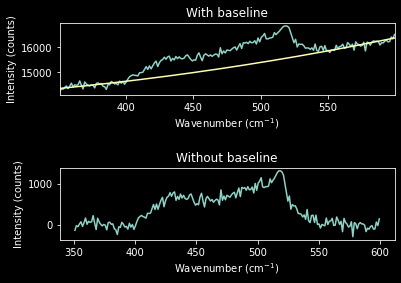

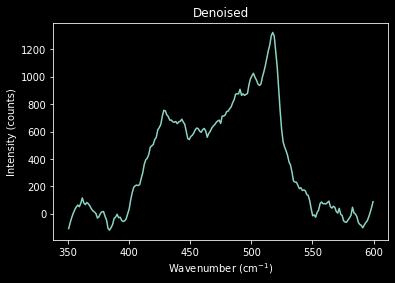

Amplitudes: [678.27457797 931.91821151 659.66368028]
Centers: [433.6375261  495.81954194 517.30646574]
Sigmas: [ 17.22661036 -25.05247297   4.82285976]


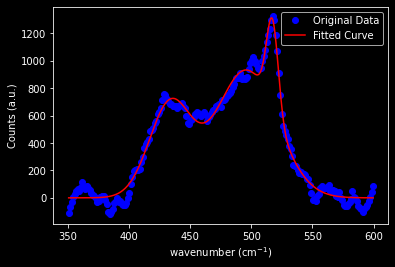

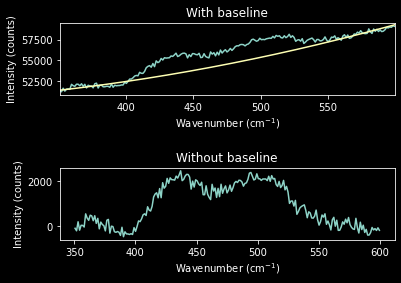

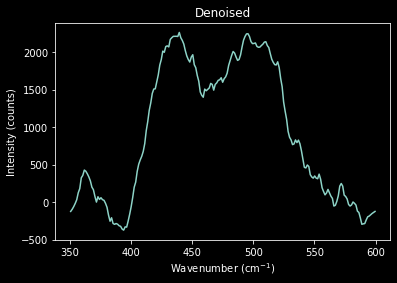

Amplitudes: [2082.05799845 2107.22309621  387.64282265]
Centers: [433.61695182 494.66098718 515.75044507]
Sigmas: [15.36269472 28.31451855  6.77079875]


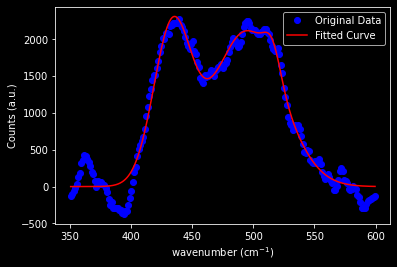

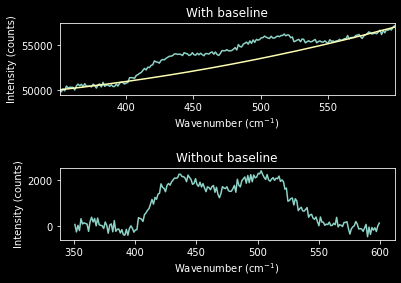

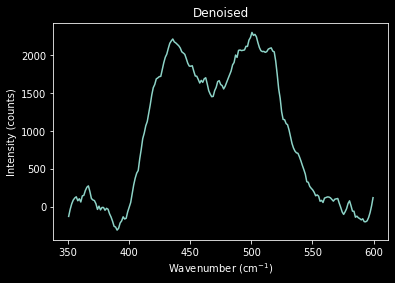

Amplitudes: [1799.83672245 1608.10254319 1027.45159868]
Centers: [433.34771883 485.13525208 512.16512399]
Sigmas: [15.68209161 30.18833124 15.96896171]


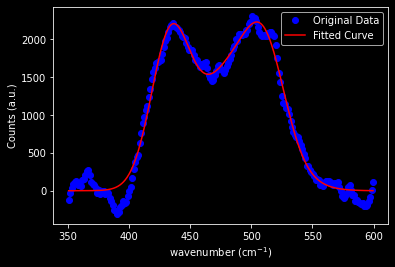

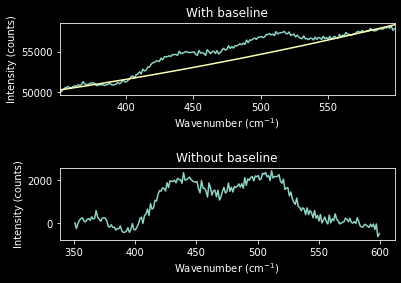

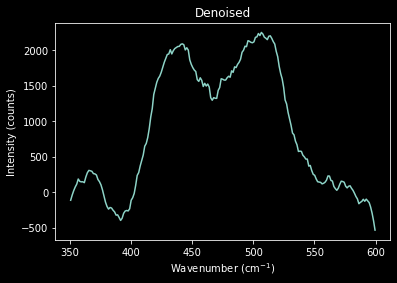

Amplitudes: [1887.43250309 1777.49656162  830.03408298]
Centers: [434.71440803 491.99314589 513.34045303]
Sigmas: [15.0150416  29.18178718 11.57646926]


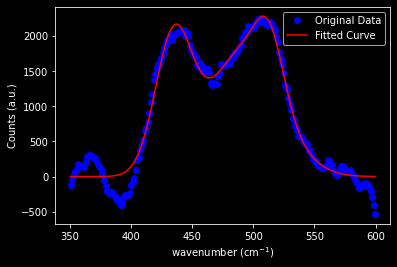

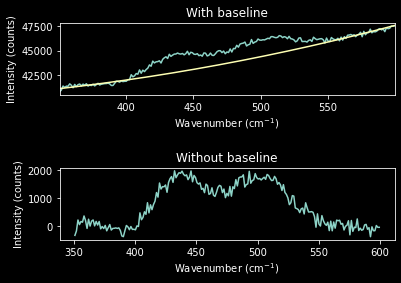

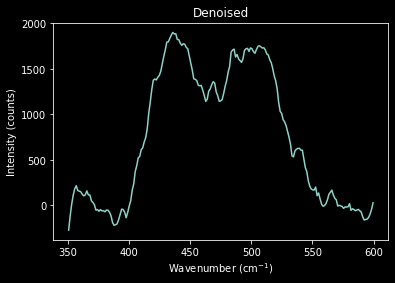

Amplitudes: [1769.85492154 1690.72895319  284.93903433]
Centers: [435.20081071 496.58906748 513.47449262]
Sigmas: [16.34135153 27.07738534  6.02526738]


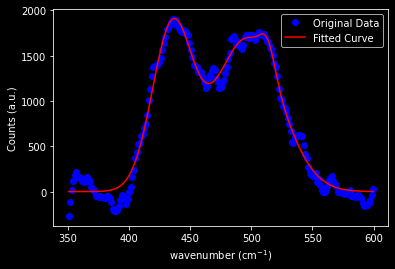

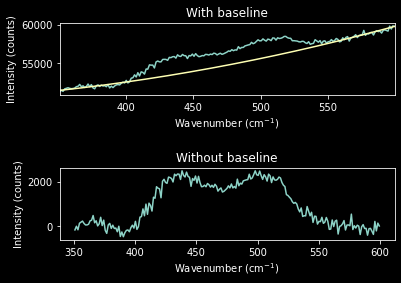

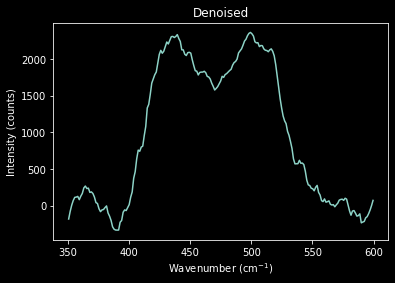

Amplitudes: [1893.62921686 1745.0060836  1044.25619288]
Centers: [432.39650581 483.536487   511.73113615]
Sigmas: [15.53172801 30.93745326 14.72530642]


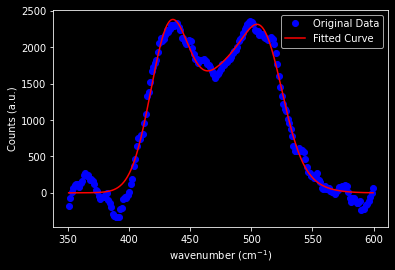

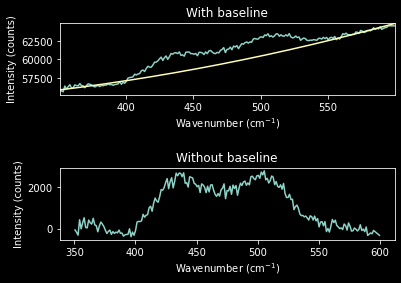

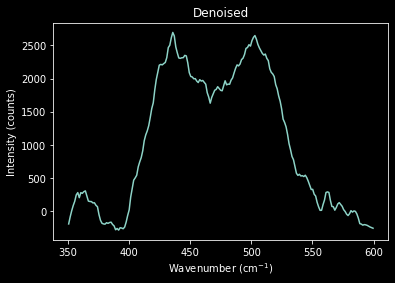

Amplitudes: [2065.63699474 1923.47167928  986.77291713]
Centers: [433.12664869 486.67046814 510.54458316]
Sigmas: [15.34264473 31.59827686 13.55407242]


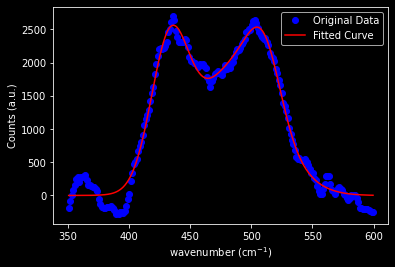

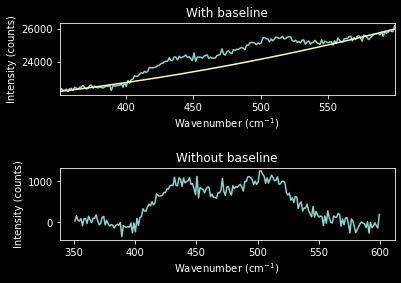

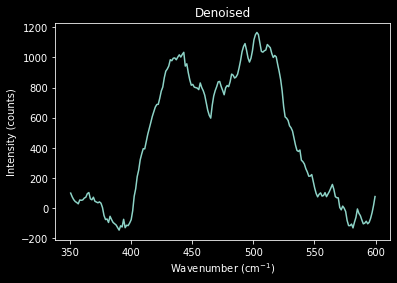

Amplitudes: [888.15992148 925.13901116 319.83441969]
Centers: [433.9783964  493.43305559 513.55783343]
Sigmas: [15.75798078 29.62811326 12.09003309]


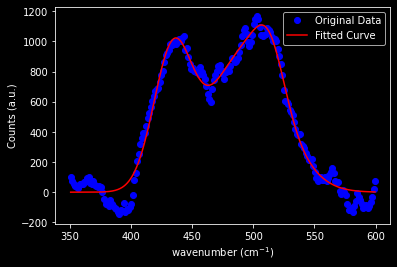

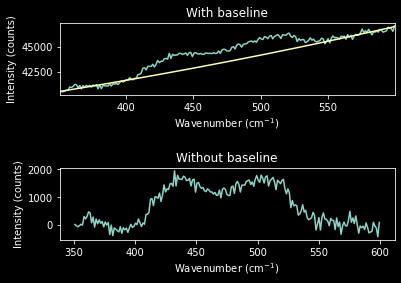

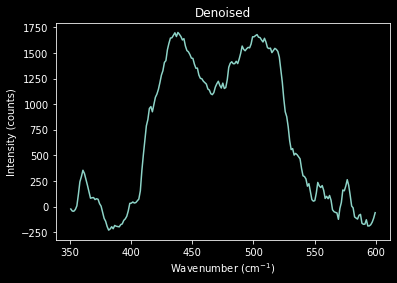

Amplitudes: [1555.3443339  1457.34742508  568.63296519]
Centers: [435.25454328 492.28109291 515.37750574]
Sigmas: [15.73679737 26.7154297  10.31188483]


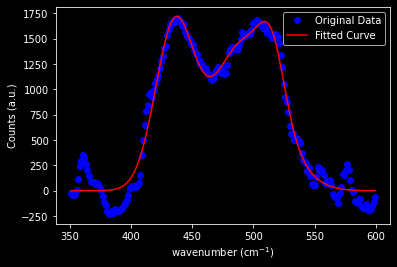

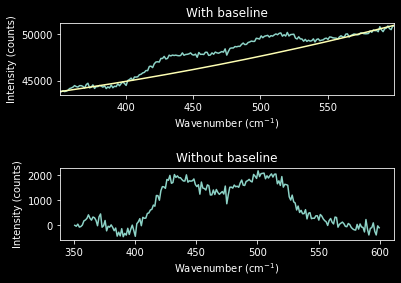

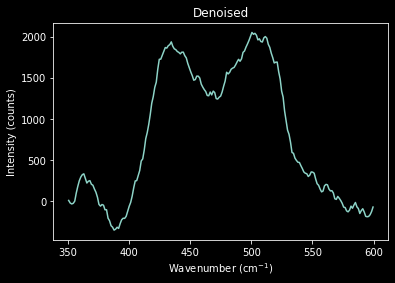

Amplitudes: [1679.30831689 1543.1888421   828.59347348]
Centers: [433.69598482 489.10663145 512.30531473]
Sigmas: [14.45282476 30.47459911 12.3999113 ]


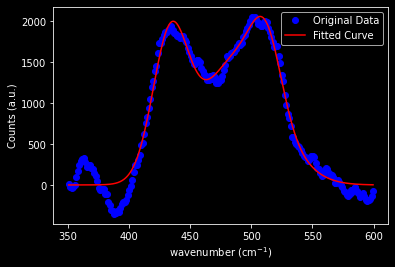

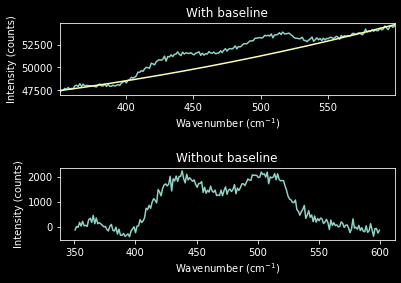

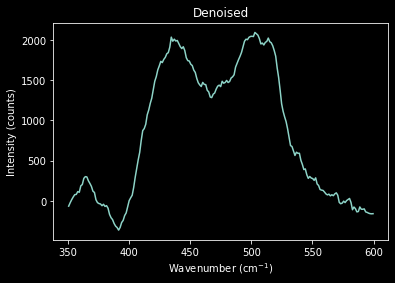

Amplitudes: [1734.22124678 1545.35337257  856.67513582]
Centers: [433.69880751 489.65015592 511.60891517]
Sigmas: [15.66540404 30.4593288  12.66944536]


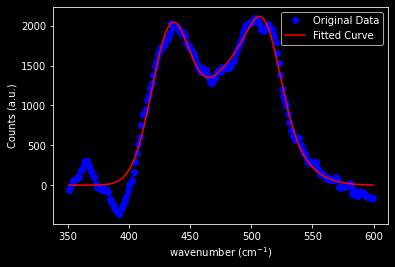

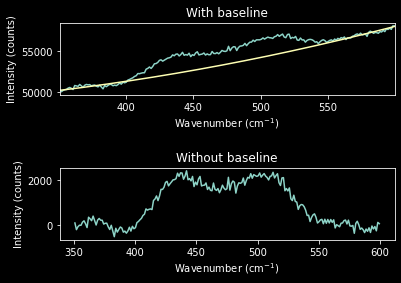

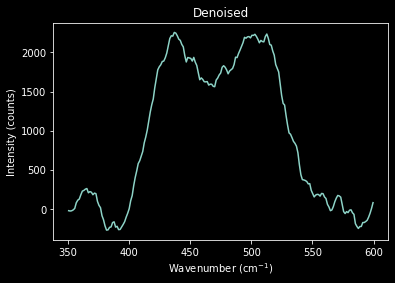

Amplitudes: [1824.48315126 1759.56866371  991.81855171]
Centers: [433.73177518 485.9307145  514.16506739]
Sigmas: [15.35850096 29.71666196 14.47943528]


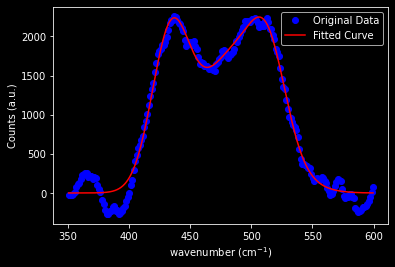

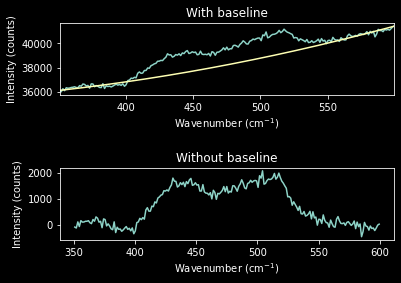

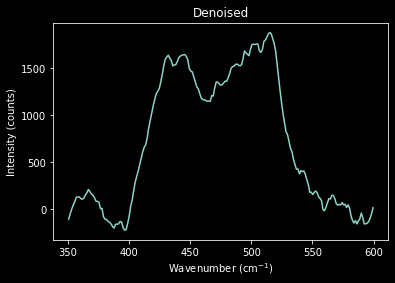

Amplitudes: [1548.11552682 1628.23186491  660.56738484]
Centers: [435.49101332 494.78935017 516.29329228]
Sigmas: [16.22579186 26.75592336  6.68771022]


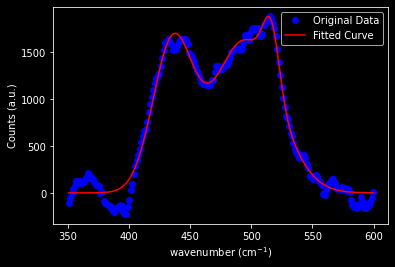

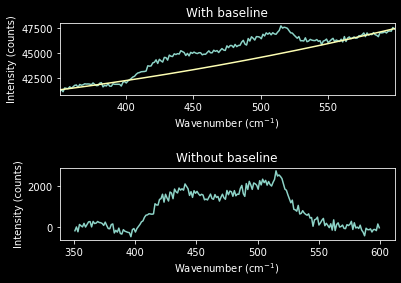

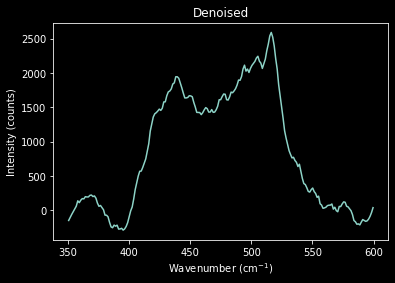

Amplitudes: [1738.70313861 2046.74349918  959.21395818]
Centers: [435.92829907 497.02119311 517.05997752]
Sigmas: [16.64758265 26.37312069  5.19336809]


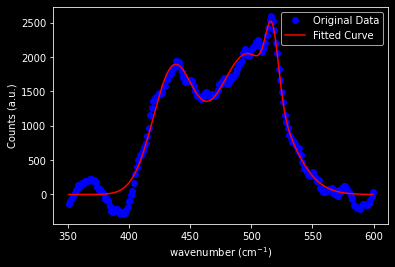

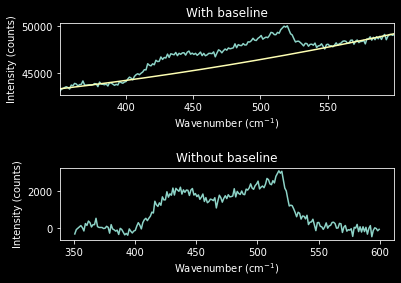

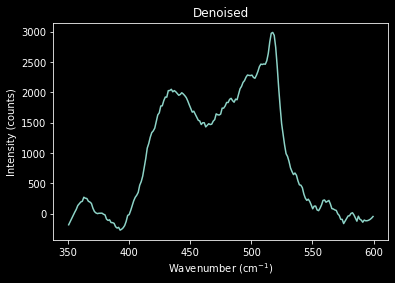

Amplitudes: [1996.05616834 2216.0812603  1382.05977823]
Centers: [435.94399857 496.28414197 517.22757479]
Sigmas: [16.46489161 24.65399136  5.15549589]


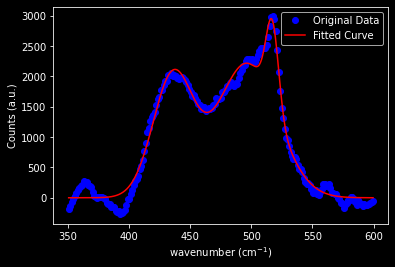

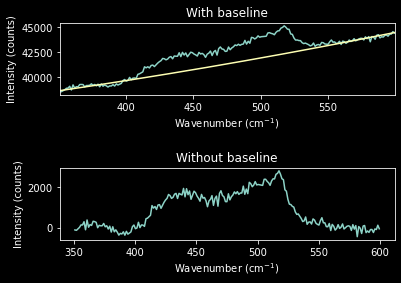

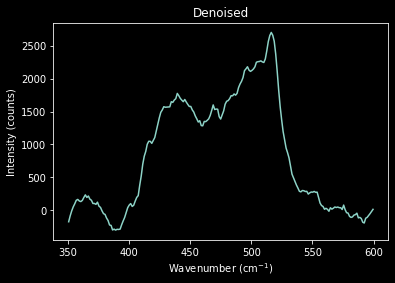

Amplitudes: [1672.43336059 2065.11173472 1193.24172218]
Centers: [437.07155273 496.6707463  516.80817408]
Sigmas: [17.35153451 23.65863526  5.56375518]


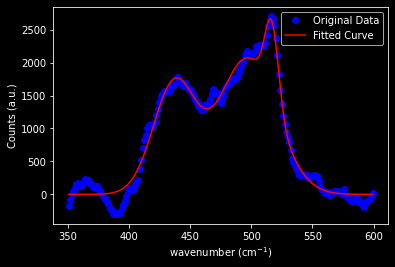

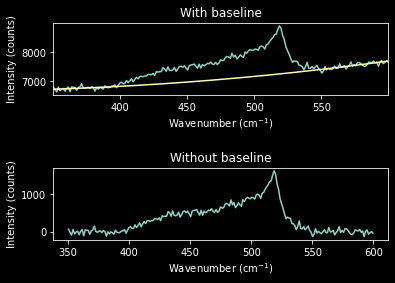

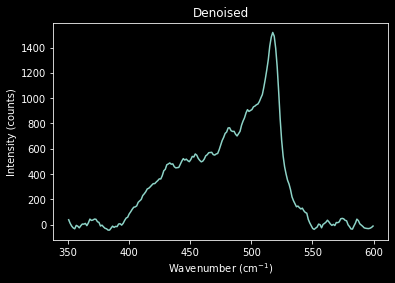

Amplitudes: [516.54384598 850.18439095 886.87743072]
Centers: [446.65450384 501.84408128 517.71554774]
Sigmas: [25.54116352 19.29895112  4.77464504]


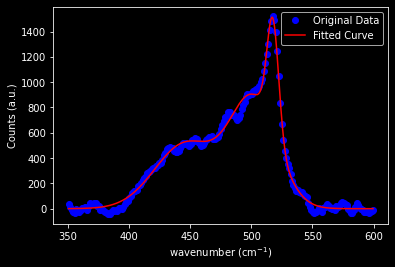

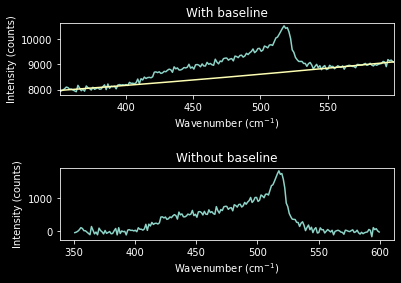

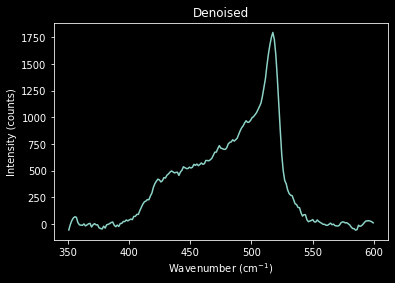

Amplitudes: [ 547.74475536  927.69929125 1113.27461054]
Centers: [448.55565932 501.58422011 517.09911688]
Sigmas: [24.77897384 18.89281033  4.70271332]


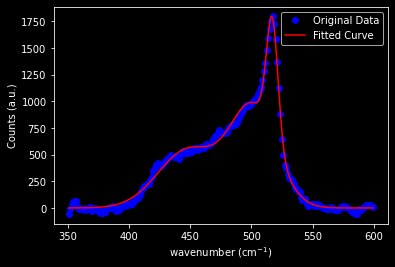

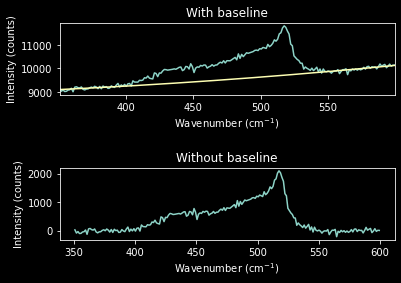

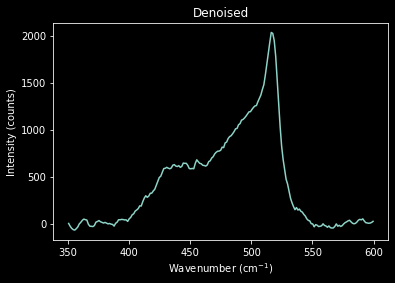

Amplitudes: [ 637.62631442 1163.32882379 1234.84243792]
Centers: [444.07657291 499.63807164 517.16728399]
Sigmas: [22.76305546 18.99171562  5.05402439]


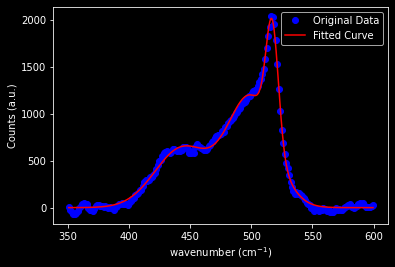

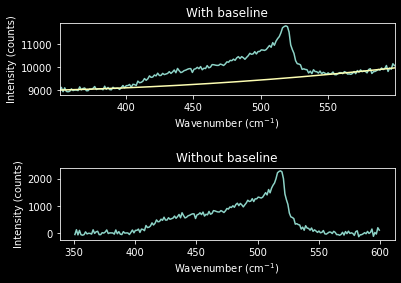

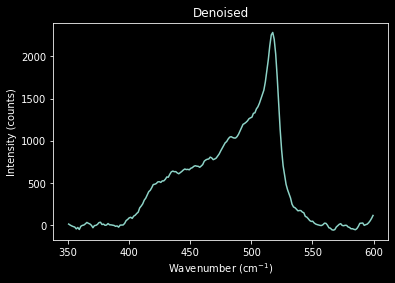

Amplitudes: [ 691.0722846  1205.16814149 1392.8347427 ]
Centers: [448.03618548 501.48444686 517.33284659]
Sigmas: [25.75747397 18.70475543  4.73508149]


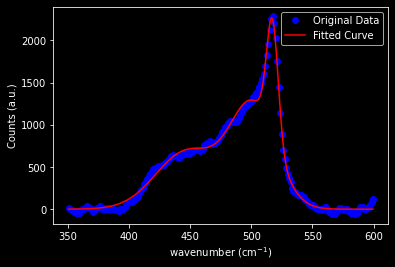

<Figure size 432x288 with 0 Axes>

In [5]:
stats = {}

for f in files:
    sp0 = RamanSpectrum(f)
    sp0.crop(lower=350, upper=600)
    sp0.polifit(a=400, b = 550, ord = 2)
    sp0.sav_gol(10,2,sp0.polylx,sp0.polyly,show=True)
    sp0.get_fitting(f2 = 0.7, f3 = 0.3 , c1 = 515, c2 = 500, c3 = 410, s1 = 10, s2 = 20, s3 = 70 ,show = True)
    stats[sp0.metadata['Acquired']] = (sp0.popt,sp0)

In [6]:
def gaussian(x, amplitude, center, sigma):
    return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

678.2745779689787 433.6375260980509 17.2266103580992
931.9182115064548 495.81954193842535 -25.052472973446225
659.663680283517 517.3064657351146 4.822859756098717
######## 

######## 

######## 

######## 

######## 

######## 
 
  pops
-25.052472973446225 [678.27457797 433.6375261   17.22661036 931.91821151 495.81954194
 -25.05247297 659.66368028 517.30646574   4.82285976]
True
######## 

######## 

######## 

######## 



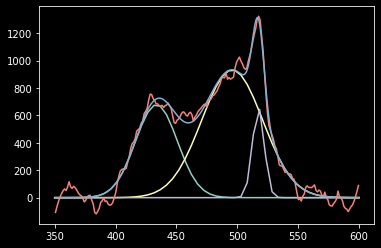

2082.0579984474457 433.61695182353066 15.362694721870698
2107.223096205396 494.66098717630774 28.314518550902257
387.64282265360987 515.7504450673457 6.770798754233585
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



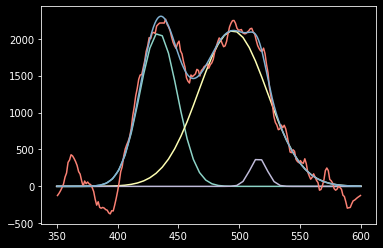

1799.8367224503902 433.34771883072074 15.682091611311256
1608.102543185332 485.13525208022685 30.188331239824443
1027.4515986752037 512.1651239872895 15.968961707065905
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



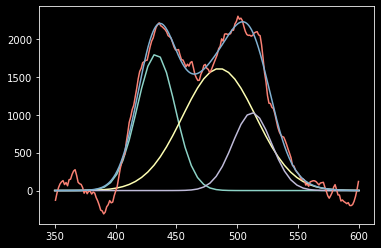

1887.4325030853006 434.7144080261052 15.015041604282604
1777.496561623243 491.9931458943223 29.18178718291665
830.0340829811614 513.3404530337125 11.576469264867145
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



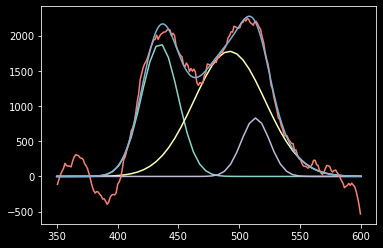

1769.8549215399448 435.2008107080791 16.34135152778085
1690.7289531930883 496.58906748381054 27.077385343481634
284.9390343343132 513.4744926203684 6.025267377092044
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



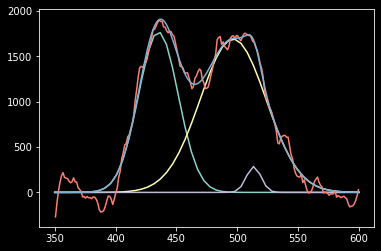

1893.6292168606585 432.3965058075728 15.531728011614673
1745.006083601141 483.53648699837026 30.93745326216519
1044.2561928830241 511.7311361450539 14.725306415379775
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



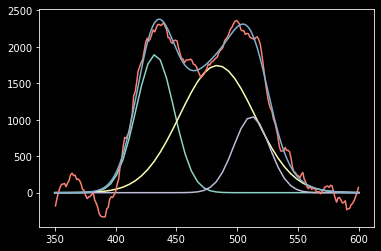

2065.636994737048 433.12664869022797 15.342644731607411
1923.471679275506 486.6704681350535 31.59827685641617
986.7729171261668 510.54458315916526 13.554072416847548
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



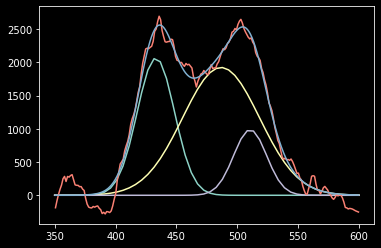

888.159921479334 433.9783964046864 15.75798077591608
925.139011162271 493.4330555910748 29.628113263851336
319.83441968881476 513.557833425921 12.090033086846226
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



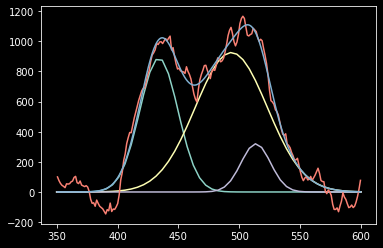

1555.344333898217 435.2545432848508 15.736797367955187
1457.3474250798176 492.2810929066512 26.715429698196452
568.6329651860426 515.3775057396815 10.311884829042917
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



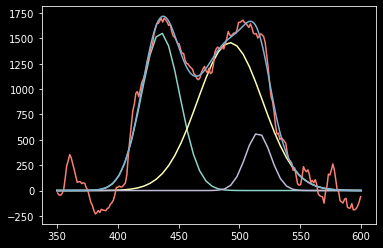

1679.3083168851954 433.69598481791246 14.452824760387685
1543.1888421014924 489.10663144802965 30.474599114896634
828.5934734832064 512.3053147269864 12.399911298858036
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



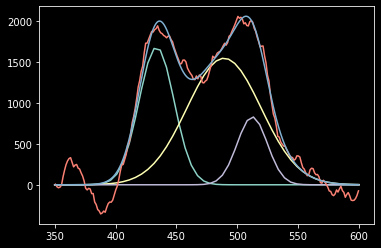

1734.221246781267 433.6988075082995 15.665404041509843
1545.3533725729828 489.65015592240894 30.4593288015654
856.6751358156848 511.6089151723322 12.66944536350932
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



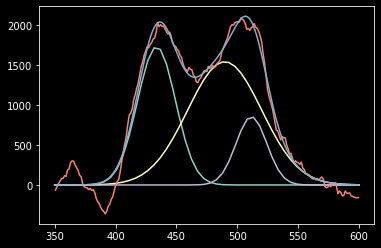

1824.4831512575954 433.7317751831531 15.358500960164932
1759.5686637055703 485.93071449510774 29.71666196276615
991.818551714114 514.165067386609 14.479435280741532
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



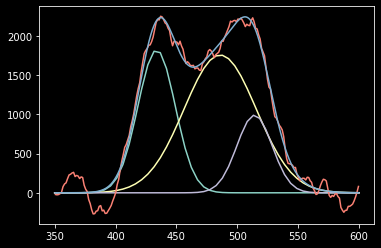

1548.1155268183145 435.4910133163674 16.22579185622056
1628.2318649141368 494.78935016624666 26.75592336335395
660.567384841916 516.2932922826324 6.687710218756946
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



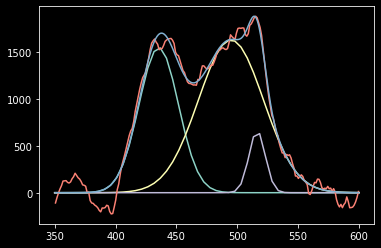

1738.7031386072595 435.928299066107 16.647582652708724
2046.743499182742 497.0211931051466 26.373120693004363
959.213958178697 517.059977515237 5.193368086316266
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



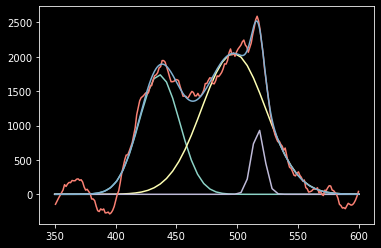

1996.0561683384055 435.94399856647965 16.464891613448856
2216.0812603017234 496.2841419727367 24.65399136297694
1382.0597782304326 517.2275747874044 5.155495891165643
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



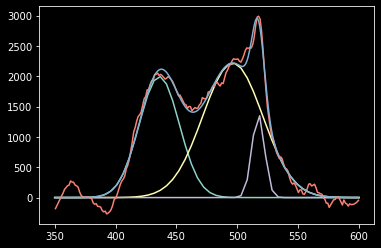

1672.4333605882152 437.0715527279096 17.351534510572172
2065.1117347206514 496.6707462982041 23.658635256252033
1193.24172217826 516.808174077428 5.563755177265486
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



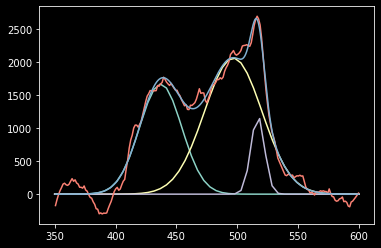

516.5438459810359 446.65450383767563 25.541163522655456
850.184390949312 501.8440812841709 19.298951115515376
886.8774307184774 517.7155477397531 4.774645041862813
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



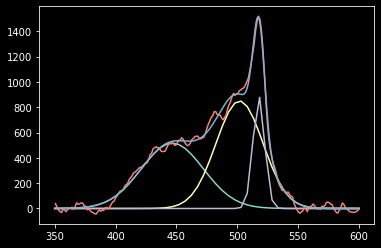

547.7447553628772 448.5556593203096 24.778973837275117
927.6992912501265 501.58422010696296 18.89281032503272
1113.2746105446952 517.0991168835706 4.702713324083338
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



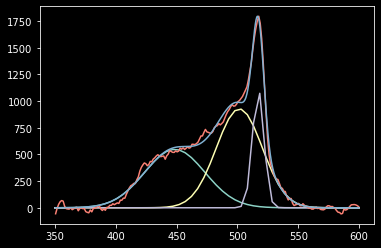

637.6263144199601 444.0765729081648 22.76305546293059
1163.3288237905092 499.6380716440632 18.991715623126673
1234.8424379174069 517.1672839925798 5.05402439208259
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



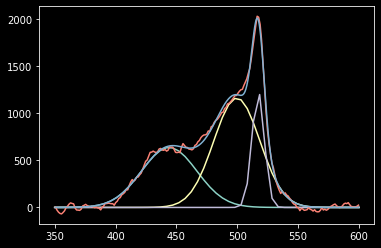

691.0722846022659 448.0361854790621 25.75747396934793
1205.1681414868178 501.4844468552324 18.704755430676055
1392.8347426979285 517.3328465933342 4.735081494052555
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



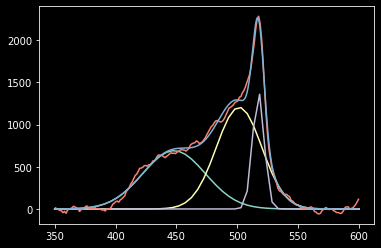

In [9]:
spectrums = list(stats.keys())
pops_data = {}

for spec in spectrums:
    ob = stats[spec][1]
    g = []
    gy = []

    x = np.linspace(350,600)

    exp_x = ob.basedx
    exp_y = ob.basedy
    fit_x = ob.x_fit
    fit_y = ob.y_fit

    for i in range(0,3):
        a,c,s = ob.popt[i*3:(i+1)*3]
        g.append([a,c,s])
        print(a,c,s)
        gy.append(gaussian(x,a,c,s))
    plt.plot(x,gy[0])
    plt.plot(x,gy[1])
    plt.plot(x,gy[2])
    plt.plot(exp_x,exp_y)
    plt.plot(fit_x,fit_y)
    for e in ob.popt:
        if e < 0:
            print('######## \n \n  pops')
            print(e, ob.popt)
            print(ob.metadata['Acquired']=='21.03.2023 10:08:20')
        print('######## \n')
    pops_data[spec] = ob.popt
    plt.savefig('frames/'+spec+'.png')
    plt.show()


In [96]:
x = []
y = []
c = 1
for name in spectrums[1:]:
    params = pops_data[name]
    for e in params:
        if e<0:
            print('Warning')
    x.append(c)
    y.append(params[])
    c += 1

plt.plot(x,y,'o')     

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2291131084.py, line 10)

In [43]:

def gaussian(self, x, amplitude, center, sigma):
    return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))


In [46]:
# Working with the popts

measurements = list(stats.keys())
m_i = measurements[0]

r = stats[m_i][1]

In [49]:
g = []

pop = r.popt

for i in range(0,3):
    a,c,s = pop[i*3:(i+1)*3]
    g.append([a,c,s])

plt.plot(x,g[0])
plt.plot(x,g[1])
plt.plot(x,g[2])

In [47]:
x = np.linspace(350,650)

for i in range(0,3):
    gs = gaussian(x,g[i][0],g[i][1],g[i][2])


Amplitudes: [ 547.74475468  927.69929139 1113.27461134]
Centers: [448.55565924 501.58422005 517.09911688]
Sigmas: [24.77897379 18.89281035  4.70271333]


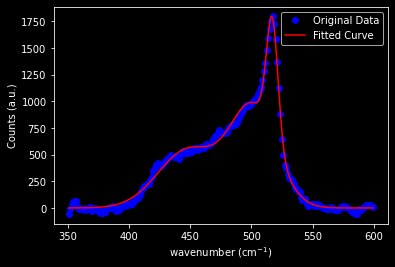

<Figure size 432x288 with 0 Axes>

In [36]:
sp0.get_fitting(f2 = 0.7, f3 = 0.3 , c1 = 515, c2 = 500, c3 = 410, s1 = 10, s2 = 20, s3 = 70 ,show = True)

In [39]:
pop = sp0.popt

In [44]:
pop

array([ 547.74475468,  448.55565924,   24.77897379,  927.69929139,
        501.58422005,   18.89281035, 1113.27461134,  517.09911688,
          4.70271333])

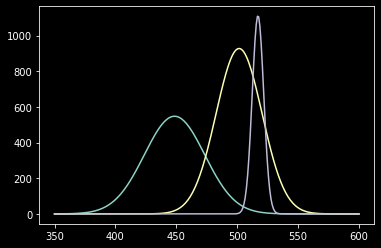

In [64]:
for e in


    s1 = pop[0:3]
    s2 = pop[3:6]
    s3 = pop[6:9]

    x = np.linspace(350,600, 250)

    def gaussian(x, amplitude, center, sigma):
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
    g = []

    for s in [s1,s2,s3]:
        g.append(gaussian(x,s[0],s[1],s[2]))

    plt.plot(x,g[0])
    plt.plot(x,g[1])
    plt.plot(x,g[2])

In [12]:
# We use gx and gy to fit this to a voigt profile
# Importing the wofz function from scipy.special

from scipy.special import wofz

def voigt(x, amp, cen, sig, gam):
    return amp * np.real(wofz(((x-cen) + 1j*gam)/sig/np.sqrt(2))) / sig / np.sqrt(2*np.pi)

# We need to define the initial guess for the parameters
center= 518
sigma = 30
gamma = -60
amplitude = 2000

# Now we can fit the data minimizing the difference between the actual data and the model using the curve_fit function from scipy.optimize

from scipy.optimize import curve_fit

# Using the initial parameters we defined above, we can fit the data

def plot_fit(xdata, ydata):
    popt, pcov = curve_fit(voigt, xdata, ydata, p0=[amplitude, center, sigma, gamma])

    # Plot the data and the fit
    plt.plot(xdata, ydata, 'b-', label='data')
    plt.plot(xdata, voigt(xdata, *popt), 'r-', label='fit')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    # Print the optimized parameters
    print('Optimized Amplitude = ', popt[0])
    print('Optimized Center = ', popt[1])
    print('Optimized Sigma = ', popt[2])
    print('Optimized Gamma = ', popt[3])
    plt.show()

plot_fit(nx, ny)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz
import ipywidgets as widgets
from IPython.display import display

def voigt(x, amp, cen, sig, gam):
    return amp * np.real(wofz(((x - cen) + 1j * gam) / sig / np.sqrt(2))) / sig / np.sqrt(2 * np.pi)

# Define the x-axis range
x = np.linspace(-100, 100, 10000)

# Create initial values for the parameters
initial_amp = 1.0
initial_cen = 0.0
initial_sig = 1.0
initial_gam = 1.0

# Create sliders for each parameter
amp_slider = widgets.FloatSlider(value=initial_amp, min=0.1, max=10.0, step=0.1, description='Amplitude:')
cen_slider = widgets.FloatSlider(value=initial_cen, min=-5.0, max=5.0, step=0.1, description='Center:')
sig_slider = widgets.FloatSlider(value=initial_sig, min=1.0, max=50.0, step=1.0, description='Sigma:')
gam_slider = widgets.FloatSlider(value=initial_gam, min=1.0, max=50.0, step=1.0, description='Gamma:')

# Define the update function
def update_plot(amp, cen, sig, gam):
    y = voigt(x, amp, cen, sig, gam)
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Voigt Curve')
    plt.ylim(0, np.max(y) + 0.5)
    plt.show()

# Create the interactive plot
interactive_plot = widgets.interactive(update_plot, amp=amp_slider, cen=cen_slider, sig=sig_slider, gam=gam_slider)

# Display the interactive plot
display(interactive_plot)


interactive(children=(FloatSlider(value=1.0, description='Amplitude:', max=10.0, min=0.1), FloatSlider(value=0…